<a href="https://colab.research.google.com/github/e71828/dig/blob/main/dig4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作业四  &emsp; k-means聚类
**任务主题**：电商行业客户价值分析

**问题背景**：随着电商行业竞争越来越激烈，推广费用也越来越高，加之电商法的出台，刷单冲销量的运营思路已经不再适应企业需求，而应该将更多的关注转向客户，做好客户运营才是企业生存的王道。运营好客户，首先要对客户价值进行分析，找出哪些是重要保持客户，哪些是发展客户，哪些是潜在客户。按客户价值分类，从而根据不同类别客户进行分类差别化，一对一等多样化、个性化的营销方式，使唤企业利润最大化。大多数网店客户多，消费行为复杂，这就需要使用科学的分析方法——RFM模型（客户价值分析方法）结合Python建立合理的客户价值评估模型来分析客户价值，并按照客户价值高低进行分类，从而实现快速定位客户。

**主要任务**：用Python实现客户价值分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 150 # 图片像素
plt.rcParams['figure.dpi'] = 300 # 分辨率
plt.rcParams.update({
    'font.family':'Times New Roman',
    # 'text.usetex': True
})

import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## 1.	读取原始数据

In [2]:
# read the first 5 lines
d = pd.read_csv('TB201812.csv')

In [3]:
print(d.columns) # first row

Index(['买家会员名', '买家实际支付积分', '买家实际支付金额', '买家应付货款', '买家应付邮费', '买家支付宝账号',
       '买家支付积分', '买家服务费', '买家留言', '修改后的sku', '修改后的收货地址', '分阶段订单信息', '卖家服务费',
       '发票抬头', '含应开票给个人的个人红包', '天猫卡券抵扣', '定金排名', '宝贝总数量', '宝贝标题 ', '宝贝种类 ',
       '店铺Id', '店铺名称', '异常信息', '总金额', '打款商家金额', '支付单号', '支付详情', '收货人姓名',
       '收货地址', '新零售交易类型', '新零售发货门店id', '新零售发货门店名称', '新零售导购门店id', '新零售导购门店名称',
       '是否上传合同照片', '是否上传小票', '是否代付', '是否手机订单', '是否是O2O交易', '物流公司', '物流单号 ',
       '特权订金订单id', '确认收货时间', '联系手机', '联系电话 ', '订单付款时间', '订单关闭原因', '订单创建时间',
       '订单备注', '订单状态', '运送方式', '返点积分', '退款金额', '数据采集时间'],
      dtype='object')


## 2.	数据探索分析：
找出订单付款时间、买家会员名，买家实际支付金额、数据采集时间的空值数，以及买家实际支付金额的最大、最小值，以表格形式呈现。

In [4]:
print('订单付款时间空值:     ', d['订单付款时间'].isnull().sum())
print('买家会员名空值数:     ', d['买家会员名'].isnull().sum())
print('买家实际支付金额:     ', d['买家实际支付金额'].isnull().sum())
print('订单创建时间空值:     ', d['数据采集时间'].isnull().sum())
print('支付金额的最大值:     ', d['买家实际支付金额'].max())
print('支付金额的最小值:     ', d['买家实际支付金额'].min())

订单付款时间空值:      684
买家会员名空值数:      172
买家实际支付金额:      172
订单创建时间空值:      172
支付金额的最大值:      13246.8
支付金额的最小值:      0.0




---


|        项目       |    值   |
|:-----------------:|:-------:|
| 订单付款时间空值: |   684   |
| 买家会员名空值数: |   172   |
| 买家实际支付金额: |   172   |
| 订单创建时间空值: |   172   |
| 支付金额的最大值: | 13246.8 |
| 支付金额的最小值: |   0.0   |

---



## 3.	数据处理：主要包括数据规约、数据清理与数据转换工作。

### 1）	数据规约
提取与电商客户价值RFM模型有关的属性，即订单付款时间，买家会员名，买家实际支付金额与数据采集时间，删除其他的属性。

In [5]:
dn = d.loc[:,['订单付款时间', '买家会员名', '买家实际支付金额', '数据采集时间']]

### 2）	数据清洗
去除上述属性的空值，保留非空值。将属性转换为RFM格式，转换公式为：  
R = 数据采集时间 – 订单付款时间；  
F = 同一客户在一定时间内的购买次数；  
M = 买家实际支付金额。  
保存上述清洗后的文件。  

In [6]:
dn.dropna(inplace=True, how='any')  # drop nan values
print(dn.isnull().sum().sum()==0)  # check again

True


In [7]:
from hashlib import md5

# Apply hashing function to the column
dn['买家会员名'] = dn['买家会员名'].apply(
    lambda x: 
        md5(x.encode()).hexdigest()
)
dn.head()

,订单付款时间,买家会员名,买家实际支付金额,数据采集时间
0,2018/1/31,2e96cf9663a6f3f64ae2a94d6951437c,143.64,2018/12/31
1,2018/1/31,6f1e5e17aadc6facf7486eeca9775112,55.86,2018/12/31
2,2018/1/31,0fdb2c45365df25970e6714bb9887037,55.86,2018/12/31
3,2018/1/31,98732598e45c994f5d1e142f9b67b52f,48.86,2018/12/31
5,2018/1/31,68a6ba99dacd812b9027237e987e4967,258.00,2018/12/31


In [8]:
dn['数据采集时间'] = pd.to_datetime(dn['数据采集时间'])
dn['订单付款时间'] = pd.to_datetime(dn['订单付款时间'])

dn['R'] = (dn['数据采集时间']-dn['订单付款时间']).dt.days
dn.drop(columns=['数据采集时间', '订单付款时间'], inplace=True)
dn['F'] = dn.groupby('买家会员名')['买家会员名'].transform('count')
dn.head()

,买家会员名,买家实际支付金额,R,F
0,2e96cf9663a6f3f64ae2a94d6951437c,143.64,334,1
1,6f1e5e17aadc6facf7486eeca9775112,55.86,334,1
2,0fdb2c45365df25970e6714bb9887037,55.86,334,1
3,98732598e45c994f5d1e142f9b67b52f,48.86,334,1
5,68a6ba99dacd812b9027237e987e4967,258.00,334,2


### 3）	数据转换
对清洗后的数据进行标准化转换处理，并将表头重新命名为R,F,M，写入并保存转换后的文件。

In [9]:
dn.rename(columns={'买家会员名': 'id', '买家实际支付金额': 'M'}, inplace=True)
dn =dn[['id','R', 'F', 'M']]
dn.head(5)

,id,R,F,M
0,2e96cf9663a6f3f64ae2a94d6951437c,334,1,143.64
1,6f1e5e17aadc6facf7486eeca9775112,334,1,55.86
2,0fdb2c45365df25970e6714bb9887037,334,1,55.86
3,98732598e45c994f5d1e142f9b67b52f,334,1,48.86
5,68a6ba99dacd812b9027237e987e4967,334,2,258.00


In [10]:
df = dn
df['MT'] = df.groupby('id')['M'].transform('sum')
df.sort_values(by='R',ascending=True, inplace=True)
df.drop_duplicates(subset='id', keep='first', inplace=True)
df.drop(columns=['M'], inplace=True)
df.rename(columns={'MT': 'M'}, inplace=True)
display(df.head(5))
print(df.duplicated().any())  # check again

,id,R,F,M
899,0472425290209e208d6d30e497c34051,0,1,0.00
900,ab6d6ef85bd754f084d614885a7e62e1,0,1,77.35
901,839480fcc9c3548d4cc63dd4fe66759d,1,1,97.24
902,cb8608a7b95b6bbba07f4a770627936a,1,1,59.85
903,87ccfa273aac0b40782cf810382ebcd1,2,2,105.76


False


In [11]:
df.set_index('id', inplace=True)
df.head()

,R,F,M
id,,,
0472425290209e208d6d30e497c34051,0,1,0.00
ab6d6ef85bd754f084d614885a7e62e1,0,1,77.35
839480fcc9c3548d4cc63dd4fe66759d,1,1,97.24
cb8608a7b95b6bbba07f4a770627936a,1,1,59.85
87ccfa273aac0b40782cf810382ebcd1,2,2,105.76


In [12]:
# use min-max normalization:
df['N_R'] = (df.R-df.R.min())/(df.R.max()-df.R.min())
df['N_F'] = (df.F-df.F.min())/(df.F.max()-df.F.min())
bound = 4*df['M'].std()+ df['M'].mean()
df['M'] =  df['M'].apply(lambda x: x if x <= bound else bound )
df['N_M'] = (df.M-df.M.min())/(df.M.max()-df.M.min())
df.head().round(2)

,R,F,M,N_R,N_F,N_M
id,,,,,,
0472425290209e208d6d30e497c34051,0,1,0.00,0.0,0.00,0.00
ab6d6ef85bd754f084d614885a7e62e1,0,1,77.35,0.0,0.00,0.03
839480fcc9c3548d4cc63dd4fe66759d,1,1,97.24,0.0,0.00,0.04
cb8608a7b95b6bbba07f4a770627936a,1,1,59.85,0.0,0.00,0.03
87ccfa273aac0b40782cf810382ebcd1,2,2,105.76,0.0,0.17,0.05


In [13]:
dsave = df.copy()
dsave['M'] = dsave['M'].astype('str')
dsave.to_csv('foo.csv', encoding='utf-8-sig')

## 4.	客户聚类
客户聚类主要使用Python第三方模块sklearn模块提供的k-means聚类方法对客户数据进行聚类，其中类别数是4。聚类完成后，绘制客户类别图表，要求给出4类客户群的聚类数量，以及R,F,M值的集中区域。

In [14]:
RFM_Table = df.iloc[:, 3:6]
RFM_Table.columns = ['Recency', 'Frequency', 'Monetary_Value']
RFM_Table.index.name = 'CustomerID'
RFM_Table.describe().round(2)

,Recency,Frequency,Monetary_Value
count,1656.00,1656.00,1656.00
mean,0.43,0.05,0.08
std,0.26,0.12,0.12
min,0.00,0.00,0.00
25%,0.23,0.00,0.02
50%,0.45,0.00,0.04
75%,0.60,0.00,0.12
max,1.00,1.00,1.00


In [15]:
quantilesF=RFM_Table.quantile(q=[0.95])
quantilesF = quantilesF.to_dict()
print(quantilesF)
quantilesR = RFM_Table.quantile(q=[0.2, 0.50, 0.8])
quantilesR = quantilesR.to_dict()
print(quantilesR['Monetary_Value'])

{'Recency': {0.95: 0.8983516483516484}, 'Frequency': {0.95: 0.3333333333333333}, 'Monetary_Value': {0.95: 0.2633767547751822}}
{0.2: 0.021272503452103353, 0.5: 0.04304569005954684, 0.8: 0.11668094402709166}


In [16]:
segmented_rfm = RFM_Table.copy()

In [17]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.8]: 
        return 3
    else:
        return 4
    
def FScore(x,p,d):
    if x <= d[p][0.95]:
        return 4
    else:
        return 1

def MScore(x,p,d):
    if x <= d[p][0.2]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1

In [18]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantilesR))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FScore, args=('Frequency',quantilesF))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary_Value'].apply(MScore, args=('Monetary_Value',quantilesR))
segmented_rfm.head().round(2)

,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile
CustomerID,,,,,,
0472425290209e208d6d30e497c34051,0.0,0.00,0.00,1,4,4
ab6d6ef85bd754f084d614885a7e62e1,0.0,0.00,0.03,1,4,3
839480fcc9c3548d4cc63dd4fe66759d,0.0,0.00,0.04,1,4,3
cb8608a7b95b6bbba07f4a770627936a,0.0,0.00,0.03,1,4,3
87ccfa273aac0b40782cf810382ebcd1,0.0,0.17,0.05,1,4,2


Best Recency score = 1: Purchased very recently. Best Frequency score = 1: highest quantity purchases. Best Monetary score = 1: spent the most.

In [19]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm.head().round(2)

,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment
CustomerID,,,,,,,
0472425290209e208d6d30e497c34051,0.0,0.00,0.00,1,4,4,144
ab6d6ef85bd754f084d614885a7e62e1,0.0,0.00,0.03,1,4,3,143
839480fcc9c3548d4cc63dd4fe66759d,0.0,0.00,0.04,1,4,3,143
cb8608a7b95b6bbba07f4a770627936a,0.0,0.00,0.03,1,4,3,143
87ccfa273aac0b40782cf810382ebcd1,0.0,0.17,0.05,1,4,2,142


In [20]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head().round(2)

,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
0472425290209e208d6d30e497c34051,0.0,0.00,0.00,1,4,4,144,9
ab6d6ef85bd754f084d614885a7e62e1,0.0,0.00,0.03,1,4,3,143,8
839480fcc9c3548d4cc63dd4fe66759d,0.0,0.00,0.04,1,4,3,143,8
cb8608a7b95b6bbba07f4a770627936a,0.0,0.00,0.03,1,4,3,143,8
87ccfa273aac0b40782cf810382ebcd1,0.0,0.17,0.05,1,4,2,142,7


In [21]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='314']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  7
Loyal Customers:  38
Big Spenders:  280
Lost Customers:  0
Lost Cheap Customers:  72


In [22]:
segmented_rfm['RFM_Score'].unique()

array([ 9,  8,  7,  6,  3,  4, 10, 11,  5, 12], dtype=int64)

In [23]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count'] }).round(2)

Recency Frequency Monetary_Value      
             mean      mean           mean count
RFM_Score                                       
3            0.07      0.67           0.46     7
4            0.09      0.50           0.09     1
5            0.34      0.57           0.29    24
6            0.10      0.18           0.23    34
7            0.08      0.06           0.08   110
8            0.28      0.08           0.17   229
9            0.41      0.05           0.10   483
10           0.54      0.02           0.05   426
11           0.52      0.01           0.02   270
12           0.77      0.00           0.01    72

**K-means gives the best result under the following conditions:**
- Data’s distribution is not skewed.
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

### K-Means Clustering

In [24]:
RFM_Table_scaled = RFM_Table.copy()
RFM_Table_scaled.describe().round(2)

,Recency,Frequency,Monetary_Value
count,1656.00,1656.00,1656.00
mean,0.43,0.05,0.08
std,0.26,0.12,0.12
min,0.00,0.00,0.00
25%,0.23,0.00,0.02
50%,0.45,0.00,0.04
75%,0.60,0.00,0.12
max,1.00,1.00,1.00


In [25]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1, init='random', learning_rate='auto')
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

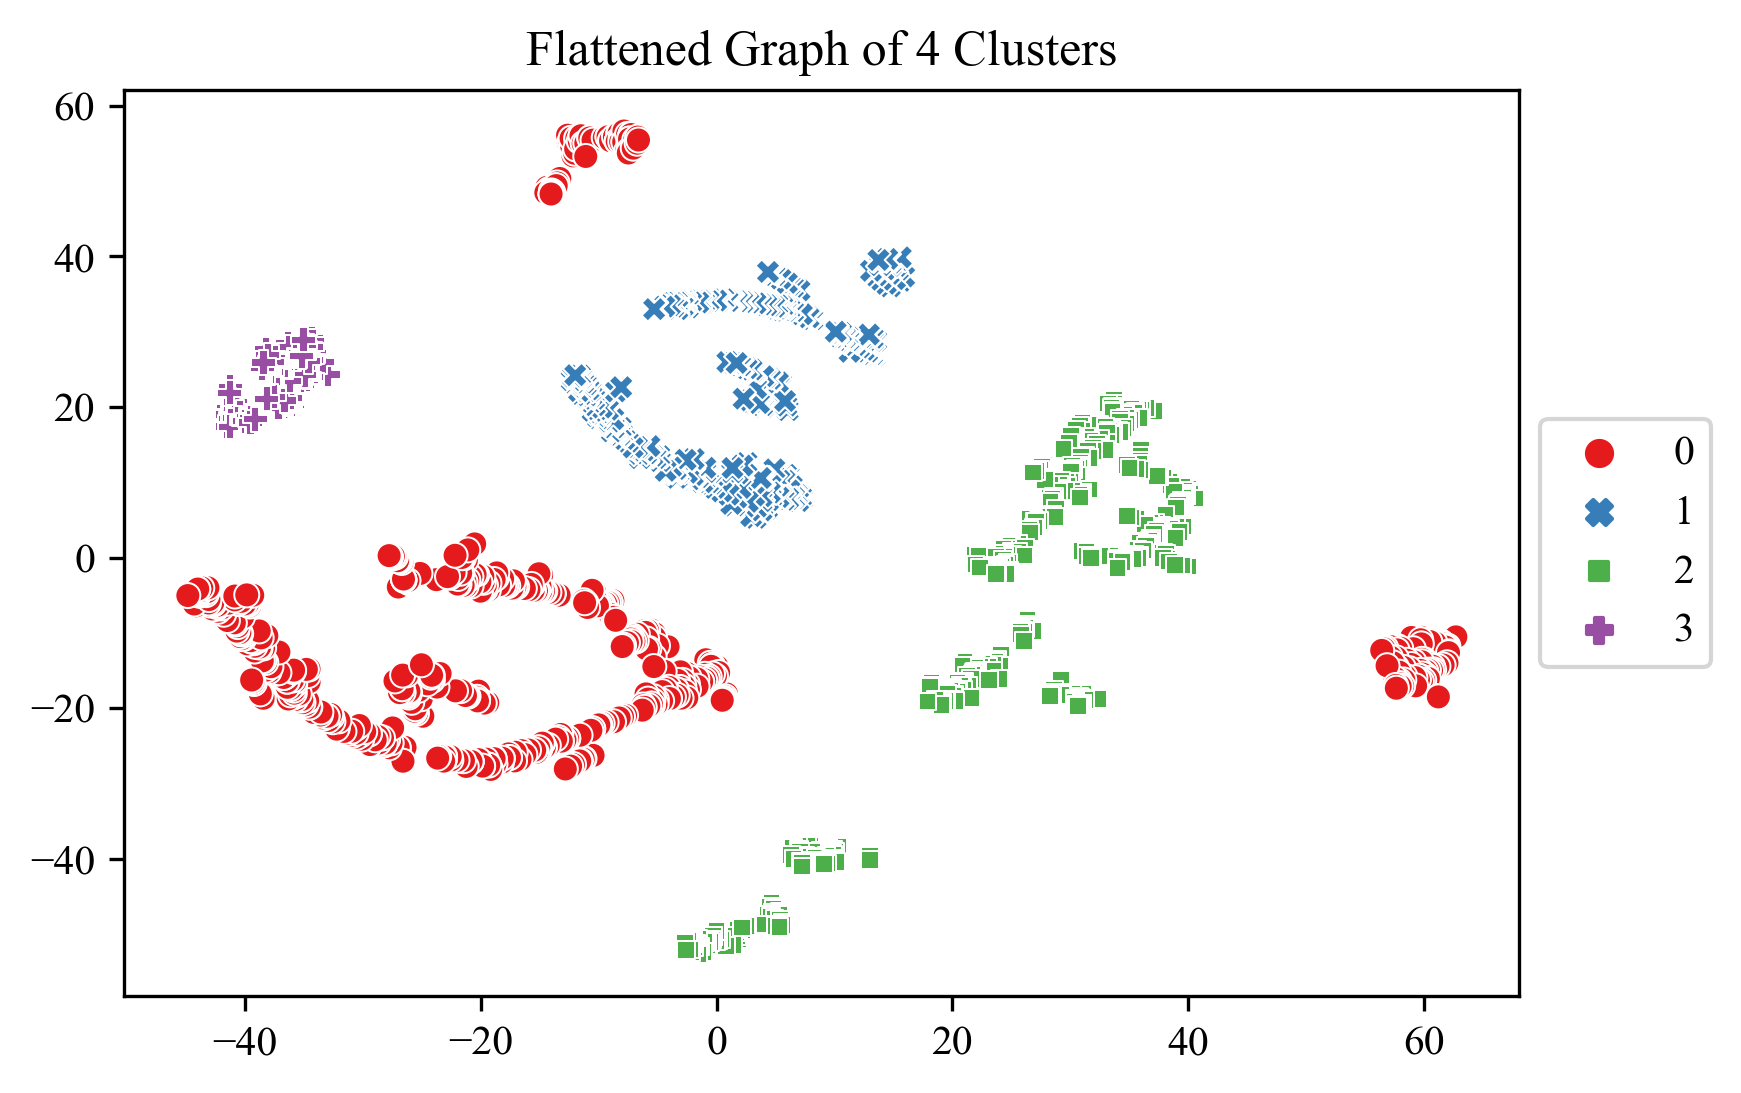

In [26]:
plt.figure()
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('flattened.png', format='png', dpi=1000)

In [27]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary_Value'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

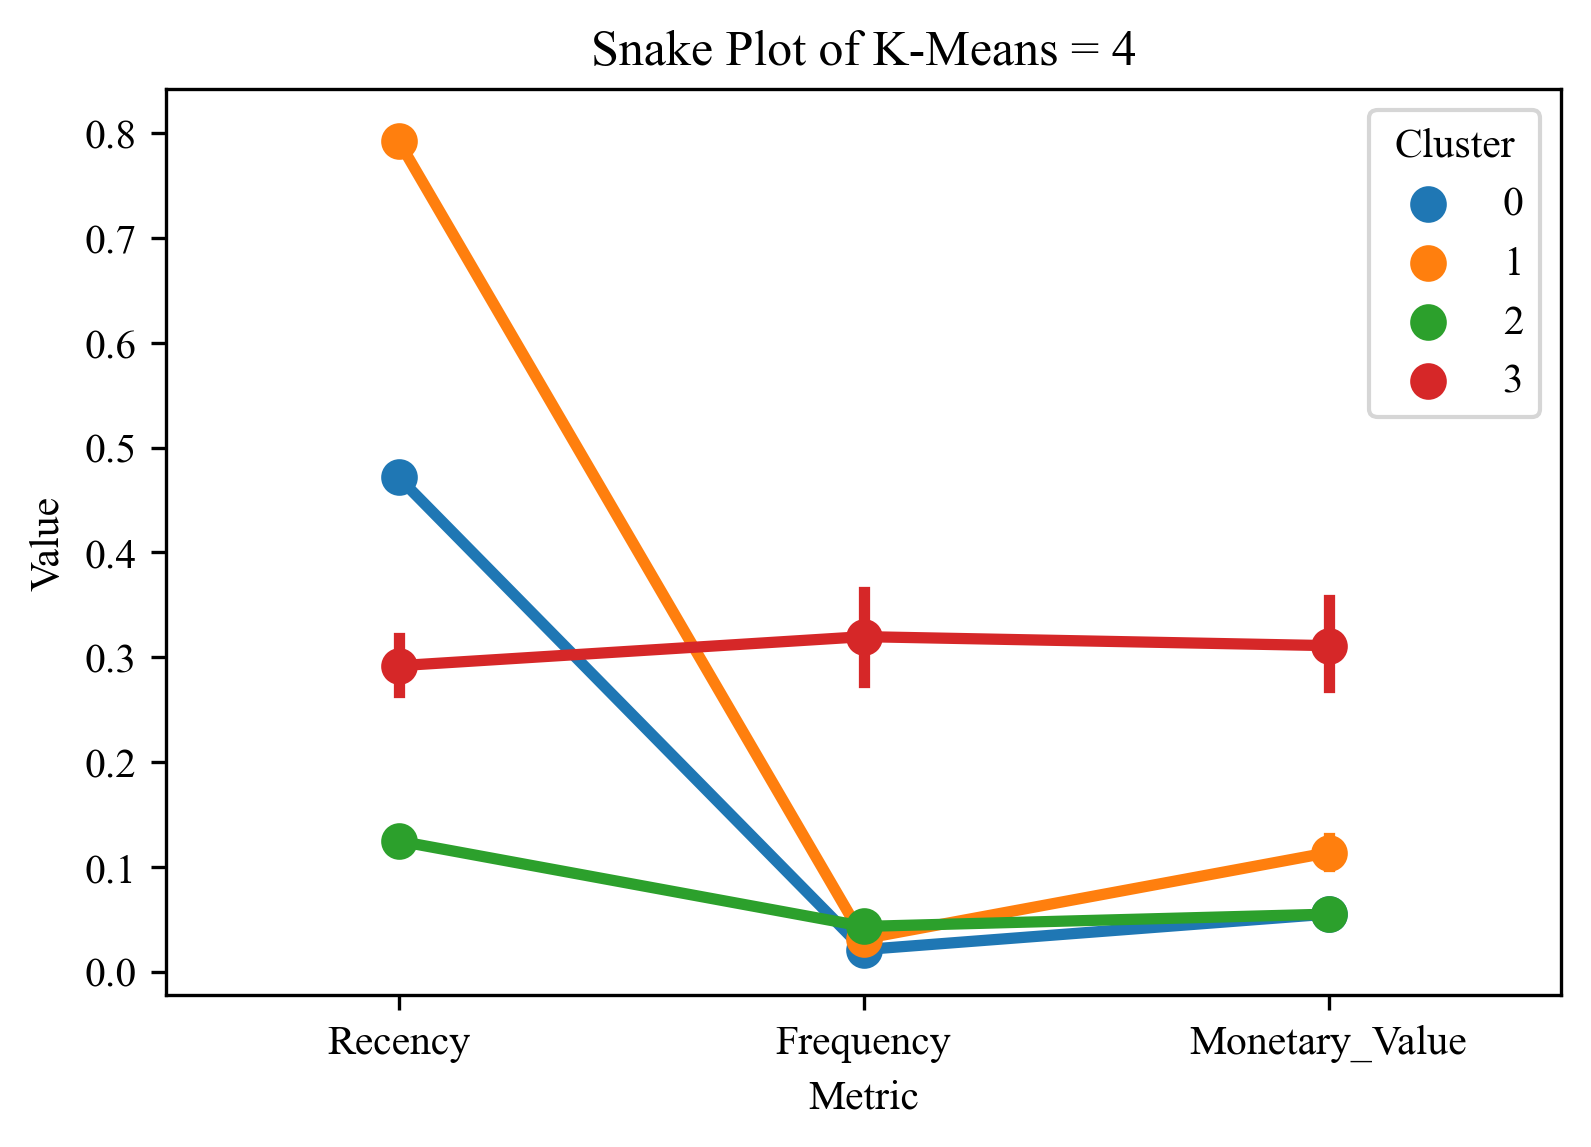

In [28]:
plt.figure()
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

From the flattened graphs and the snake plots it is evident that having a cluster value of 4,segments our customers well. We could also go for higher number of clusters, it completely depends on how the company wants to segment their customers.

### 聚类解释

In [29]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': ['mean', 'count']
    }).round(2)
    
    return df_new

In [30]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0          0.47      0.02           0.05   678
1          0.79      0.03           0.11   373
2          0.12      0.04           0.05   496
3          0.29      0.32           0.31   109

## 5.	客户价值分析
给出所聚的4类中R,F,M值与聚类类别的关系，即某一类所对应的RFM值的大小，及对应的客户数。

- Cluster 0: 表示花钱较少，买得最少，无论新老客户； 有 678 人。
- Cluster 1: 表示花钱较多，买得较少，但是最近不来了的客户； 有 373 人。
- Cluster 2: 表示花钱较少，买得较多，尤其新客户； 有 496 人。
- Cluster 3: 表示花钱非常多，买得非常多，忠实客户； 有 109 人。

**针对细分客户的建议营销策略：**

- 大宗客户：Cluster 3：  推销您最昂贵的产品。共 109 人。
- 最佳客户：Cluster 2：  无需价格激励，推出新产品和忠诚度计划。 共 496 人。
- 遗忘用户：Cluster 1：  激进的价格激励措施及合适的宣传。 共 373 人。
- 普通客户：Cluster 0：  活着就好，随缘。 共 678 人。